<a href="https://colab.research.google.com/github/shanj4321/MyKaggleProjects/blob/main/Titanic_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭕ Importing files and Essential Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import mutual_info_classif         # For evaluation the information gain for each feature
from sklearn.feature_selection import chi2, SelectKBest           # For Chi Square Test

In [ ]:
! rm -r /root/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
! mkdir /root/.kaggle

In [ ]:
! cp /content/drive/MyDrive/ColabNotebooks/DeepLearning/kaggle.json /root/.kaggle

In [ ]:
import kaggle

In [ ]:
! kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 63.0MB/s]


In [ ]:
! unzip -q titanic.zip

In [ ]:
train_df = pd.read_csv("train.csv")
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.65,NaN,S
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.00,A19,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.00,NaN,S
137,138,0,1,"Futrelle, Mr. Jacques Heath",male,37.0,1,0,113803,53.10,C123,S
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.00,NaN,S


# ⭕ Analyzing Data

In [ ]:
train_df.shape

(891, 12)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
train_df["Survived"].value_counts()/train_df.shape[0]

0    0.616162
1    0.383838
Name: Survived, dtype: float64

<Axes: xlabel='Survived', ylabel='count'>

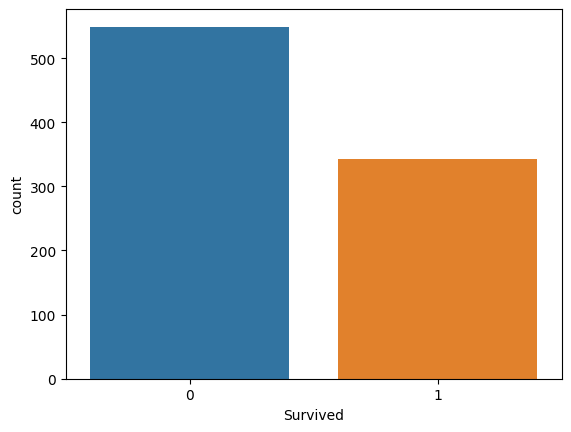

In [ ]:
sns.countplot(data=train_df, x="Survived")

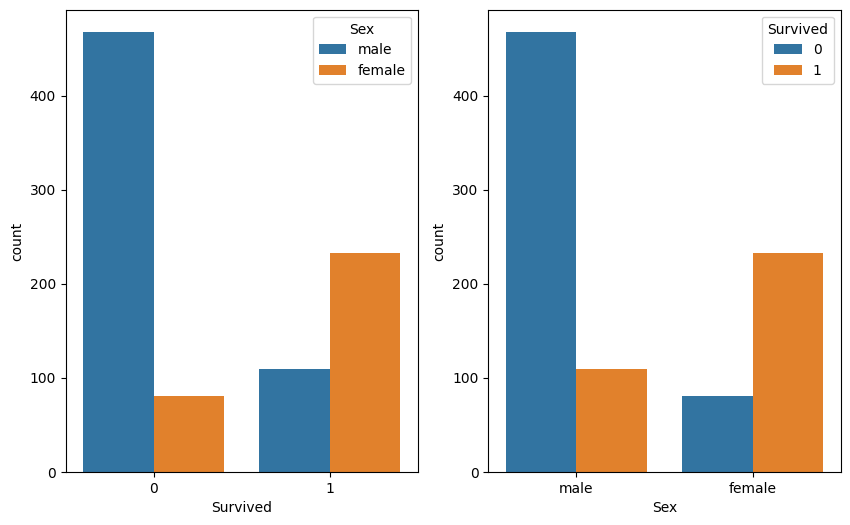

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.countplot(data=train_df, x="Survived", hue = 'Sex', ax=ax[0])
sns.countplot(data=train_df, x='Sex', hue ="Survived", ax=ax[1])
fig.show()

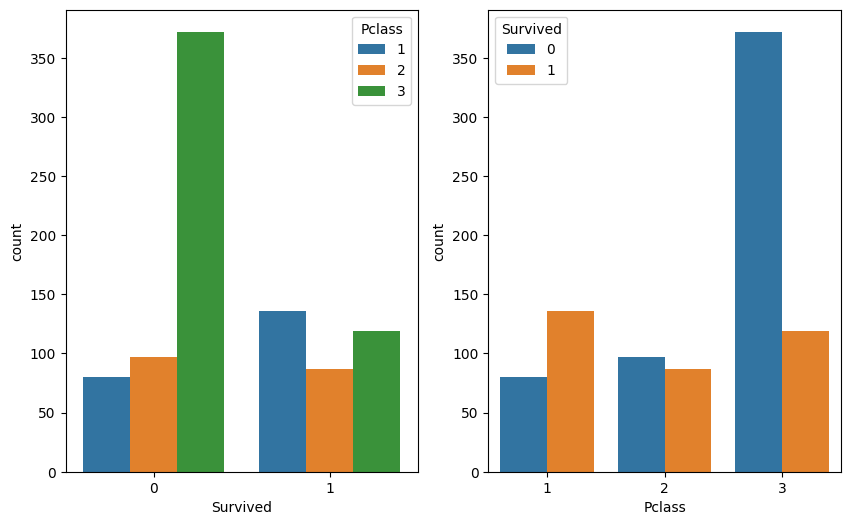

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.countplot(data=train_df, x="Survived", hue = 'Pclass', ax=ax[0])
sns.countplot(data=train_df, x='Pclass', hue ="Survived", ax=ax[1])
fig.show()

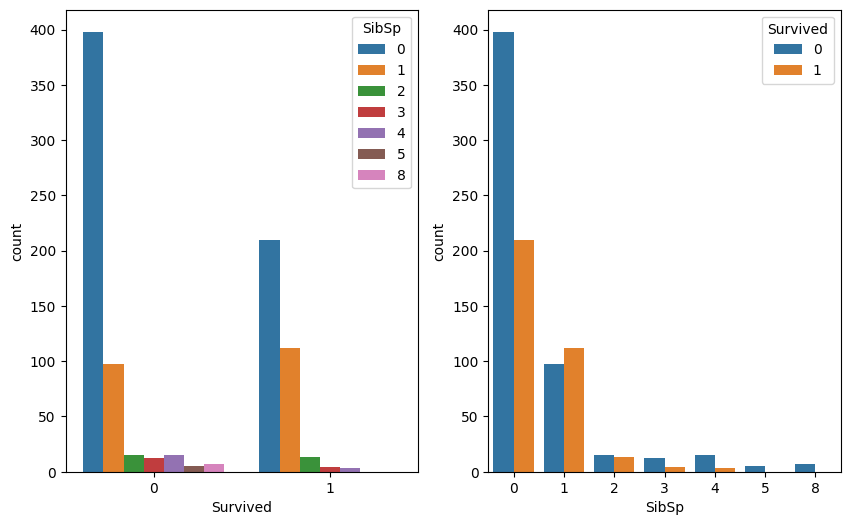

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.countplot(data=train_df, x="Survived", hue = 'SibSp', ax=ax[0])
sns.countplot(data=train_df, x='SibSp', hue ="Survived", ax=ax[1])
fig.show()

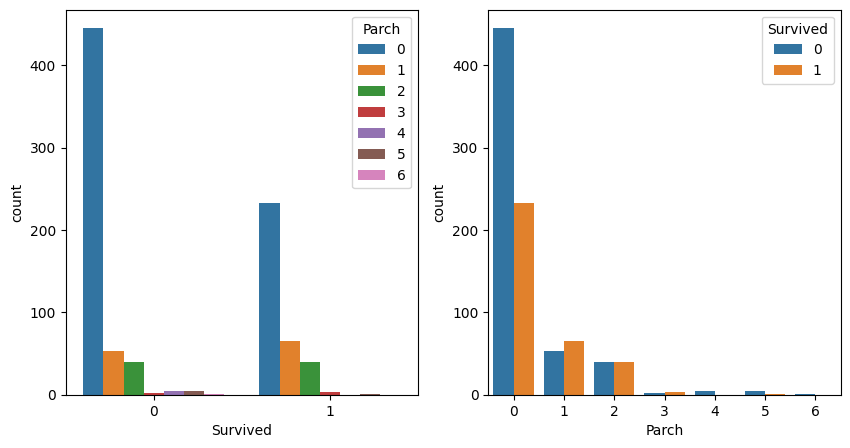

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.countplot(data=train_df, x="Survived", hue = 'Parch', ax=ax[0])
sns.countplot(data=train_df, x='Parch', hue ="Survived", ax=ax[1])
fig.show()

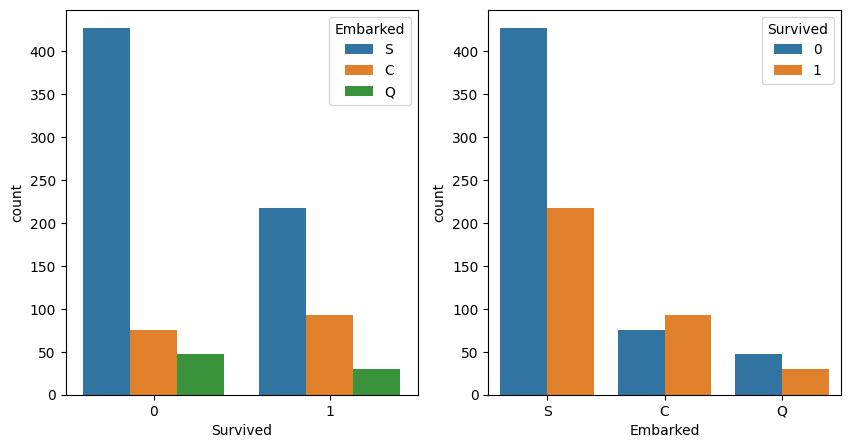

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.countplot(data=train_df, x="Survived", hue = 'Embarked', ax=ax[0])
sns.countplot(data=train_df, x='Embarked', hue ="Survived", ax=ax[1])
fig.show()

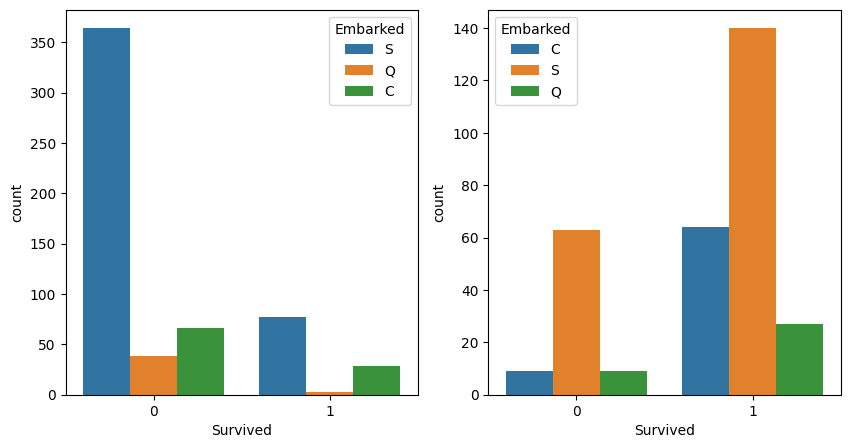

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.countplot(data=train_df[train_df['Sex']=="male"], x="Survived", hue = 'Embarked', ax=ax[0])
sns.countplot(data=train_df[train_df['Sex']=="female"], x="Survived", hue = 'Embarked', ax=ax[1])
fig.show()

In [ ]:
Age = train_df[~train_df["Age"].isna()]["Age"]
survival = train_df[~train_df["Age"].isna()]["Survived"]

In [ ]:
Age = Age.reset_index(drop=True)

<Figure size 1300x500 with 0 Axes>

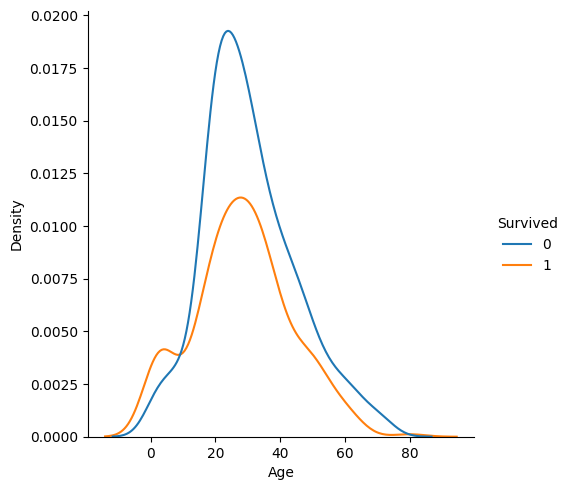

In [ ]:
plt.figure(figsize=(13,5))
sns.displot(data=train_df[~train_df["Age"].isna()], x="Age", kind="kde", hue="Survived")
plt.show()

1. Women are more likely to survive
2. Class 3 Passangers are least likely to survive
3. Having more siblings or parents means less survival chance
4. Having Parents or Child means less survival chance


# ⭕ Data Wrangling

In [ ]:
def wrangle_data(df1):
  df = df1.copy()
  le = LabelEncoder()
  # drop cabin feature because there are a lop of missing values
  df = df.drop(columns=["Cabin"])

  # Replace missiing values in Embarked with mode
  Replace_embark = df["Embarked"].value_counts().index[0]
  df["Embarked"].fillna(Replace_embark, inplace=True)

  # Replace missing Age with mean (meadian works too)
  df["Age"].fillna(df["Age"].dropna().mean(), inplace=True)
  df["Age"] = df['Age'].astype(int)

  # Replace missing Age with mean (meadian works too)
  df["Fare"].fillna(df["Fare"].dropna().mean(), inplace=True)
  df['FareBand'] = pd.qcut(df['Fare'], 4)

  # Buidling new feature AgeBand
  df['AgeBand'] = pd.cut(df['Age'], 5)

  # Building a new feature based on if peroson is alone or with family
  df['IsAlone'] =  0
  df['FamilySize'] = df["SibSp"] + df["Parch"] +1
  df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
  df = df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

  # Building a new feature to extract information from names
  title = df["Name"].str.split(" ").apply(lambda x : x[1])
  c = title.value_counts()
  rare = c[c<10].index
  title = title.replace(rare, 'rare')
  df['Title'] = title



  # Label incoding all the catagorical features
  df['Ticket'] = le.fit_transform(df["Ticket"])
  df['Sex'] = le.fit_transform(df['Sex'])
  df['Embarked'] = le.fit_transform(df["Embarked"])
  df["AgeBand"] = le.fit_transform(df["AgeBand"])
  df["FareBand"] = le.fit_transform(df["FareBand"])
  df["Title"] = le.fit_transform(df["Title"])

  # Building a band of ticket Types and label incoding
  df['TicketType'] = pd.cut(df['Ticket'], 5)
  df['TicketType'] = le.fit_transform(df["TicketType"])

  X = df.loc[:, ["Title", 'Pclass', "Sex", "Embarked", "AgeBand", "IsAlone", "FareBand", "TicketType"]]

  try:
    # Making an exception for the test dataset
    Y = df["Survived"]
  except:
    Y = None

  return X, Y

# ⭕ Data Preparation for Training

In [ ]:
X, Y = wrangle_data(train_df)

# Standerdizing the data with MinMaxSacalar
scale = MinMaxScaler()
X_std = scale.fit_transform(X)

# splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_std, Y, test_size=0.1, random_state=0)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Validation Features Shape:', X_val.shape)
print('Validation Labels Shape:', y_val.shape)

Training Features Shape: (801, 8)
Training Labels Shape: (801,)
Validation Features Shape: (90, 8)
Validation Labels Shape: (90,)


# ⭕ Feature Selection

## Information Gain

<Axes: >

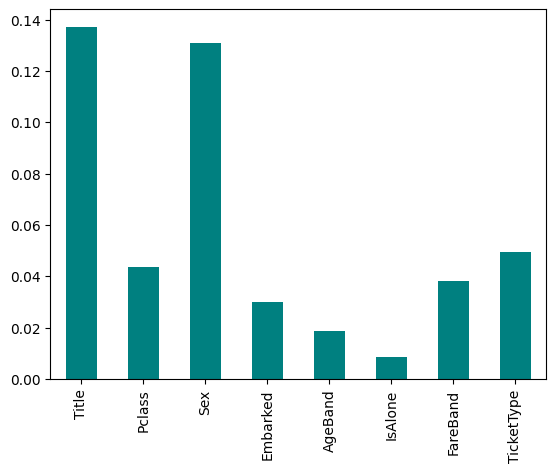

In [ ]:
importance = mutual_info_classif(X_train, y_train)
feature_imp = pd.Series(importance, X.columns)
feature_imp.plot(kind = 'bar', color='teal')

# Chi Square Test

In [ ]:
X_chi = np.copy(X.train)
Y_chi = np.copy(Y.train)
features = SelectKBest(chi2, k = 5)
best_features = features.fit_transform(X_chi, Y_chi)

# Feature Importance

In [ ]:
del rf

NameError: ignored

In [ ]:
rf = RandomForestClassifier()

rf.fit(X, Y)

RandomForestClassifier()

<Axes: >

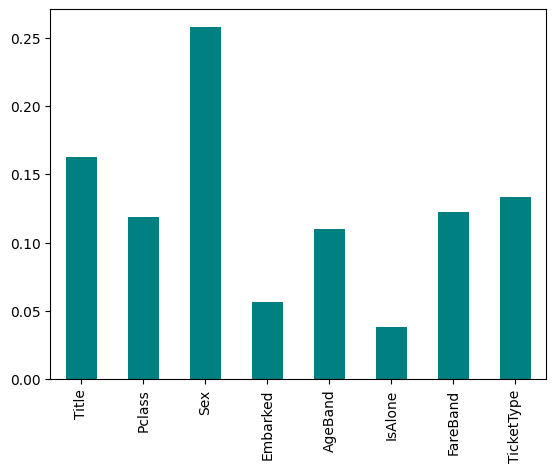

In [ ]:
f_imp = list(rf.feature_importances_)

feature_importance = pd.Series(f_imp, X.columns)
feature_importance.plot(kind= 'bar', color = 'teal')

In [ ]:
feature_importance.sort_values(ascending=False, inplace=True)

In [ ]:
features = list(feature_importance.index)

In [ ]:
features

['Sex',
 'Title',
 'TicketType',
 'FareBand',
 'Pclass',
 'AgeBand',
 'Embarked',
 'IsAlone']

In [ ]:
features[:-1]

['Sex', 'Title', 'TicketType', 'FareBand', 'Pclass', 'AgeBand', 'Embarked']

# Training with Higher importance features

In [ ]:
X_hfi = X.loc[: , features[:-1]]

# Standerdizing the data with MinMaxSacalar
scale = MinMaxScaler()
X_std = scale.fit_transform(X_hfi)

# splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_std, Y, test_size=0.1, random_state=0)

In [ ]:
del rf_max_feature

NameError: ignored

In [ ]:
rf_max_feature = RandomForestClassifier()

rf_max_feature.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf_max_feature.predict(X_val)

Accuracy :  0.8333333333333334
Confusion Matrix :


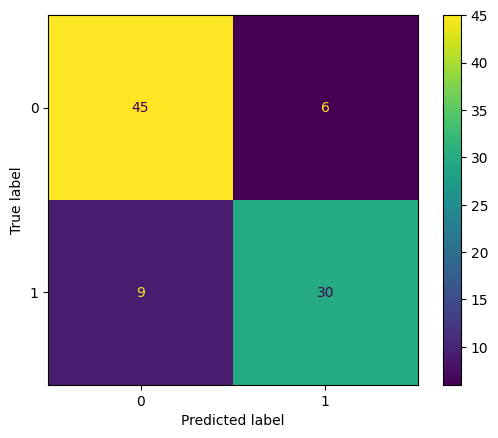

In [ ]:
print("Accuracy : ", accuracy_score(y_val, y_pred))
print("Confusion Matrix :")
cm = confusion_matrix(y_val, y_pred, labels=rf_max_feature.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_max_feature.classes_)
disp.plot()

In [ ]:
rf_max_feature.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# ⭕ Random Search (Hyperparameter Tuning)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


# Number of trees in random forest
n_estimators = [25, 50, 75, 100, 125, 150, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 12, 15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# minimum criteria for impurity decrease
min_impurity_dec = [0.0, 0.1, 0.2, 0.3, 0.4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_impurity_decrease': min_impurity_dec,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
 'min_samples_leaf': [1, 2, 4, 8, 12, 15],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [25, 50, 75, 100, 125, 150, 200]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_impurity_decrease': [0.0, 0.1, 0.2,
                                                                  0.3, 0.4],
                                        'min_samples_leaf': [1, 2, 4, 8, 12,
                                                             15],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [25, 50, 75, 100, 125,
                                                         150, 200]},
                   random_state=42, verbose=2)

In [ ]:
best_random = rf_random.best_estimator_

y_pred_best = best_random.predict(X_val)
accuracy_score(y_val, y_pred_best)

0.8444444444444444

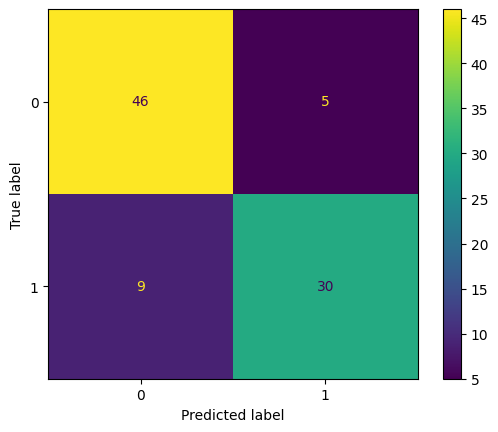

In [ ]:
cm = confusion_matrix(y_val, y_pred_best, labels=best_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_random.classes_)
disp.plot()

In [ ]:
rf_random.best_params_

{'n_estimators': 25,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [ ]:
best_random.score(X_train, y_train)

0.8826466916354557

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False, True],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
}
# Create a based model
rf_grid = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3168 candidates, totalling 9504 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False, True],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28,
                                          29, 30]},
             verbose=2)

In [ ]:
best_grid = grid_search.best_estimator_

y_pred_grid_best = best_grid.predict(X_val)
accuracy_score(y_val, y_pred_grid_best)

0.8333333333333334

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 24}

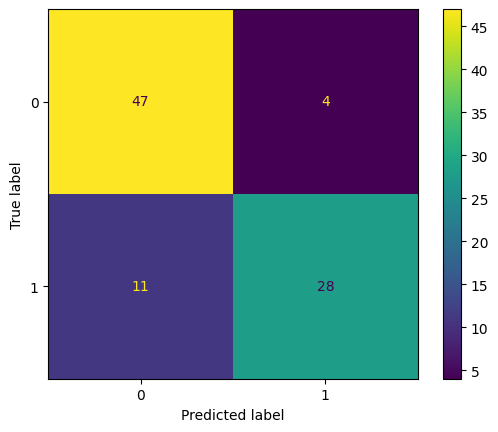

In [ ]:
cm = confusion_matrix(y_val, y_pred_grid_best, labels=best_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_grid.classes_)
disp.plot()

In [ ]:
best_grid.score(X_train, y_train)

0.8789013732833958

# ⭕ Visualizing a tree from the random forest

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = load_model.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = ['Pclass', "Sex", "Embarked", "IsAlone", "AgeBand", "FareBand", "Title"], rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

# ⭕ Training whole trian data with best hyperparameters

{'n_estimators': 25,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [ ]:
X, Y = wrangle_data(train_df)
X_hfi = X.loc[: , features[:-1]]

# Standerdizing the data with MinMaxSacalar
scale = MinMaxScaler()
X_std = scale.fit_transform(X_hfi)

rf_best_hp = RandomForestClassifier(n_estimators=25, min_samples_split=5, min_impurity_decrease=0.0, min_samples_leaf=1,
                                    bootstrap=True, max_depth=20, max_features='auto')

rf_best_hp.fit(X_std, Y)

rf_best_hp.score(X_std, Y)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8832772166105499

# ⭕ Saving The Best Model

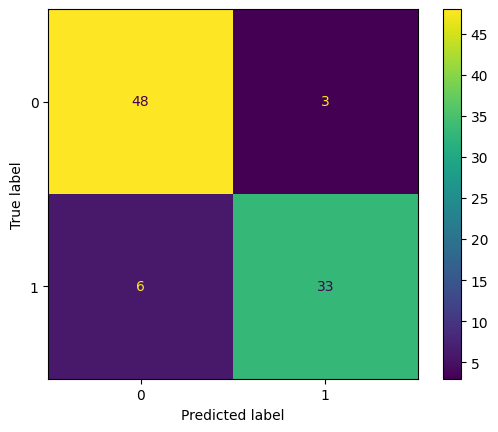

In [ ]:
# loading library

# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(rf_best_hp, files)


# load saved model
with open('model_pkl' , 'rb') as f:
    load_model = pickle.load(f)
# check prediction

y_pred2 = load_model.predict(X_val) # similar

cm = confusion_matrix(y_val, y_pred2, labels=rf_max_feature.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_max_feature.classes_)
disp.plot()

# ⭕ Making prediction using best model

In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_data, y = wrangle_data(test_df)
test_data = test_data.loc[:, features[:-1]]
scale2 = MinMaxScaler()

test_data = scale2.fit_transform(test_data)

prediction = load_model.predict(test_data)

submission = pd.DataFrame()
submission["PassengerId"] = test_df["PassengerId"]
submission["Survived"] = prediction

submission.to_csv('submission.csv', index=False)